# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [1]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'deaths'  # Variable of interest - 'confirmed' or 'deaths'
metric_min = {'confirmed': round(2**10), 'deaths': round(2**5)}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 14  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 21  # Number of days ahead to predict

In [2]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [3]:
import sys

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [5]:
# Check package versions
assert sys.version[:3] == '3.7', f'Unexpected Python version: expected 3.7, got {sys.version[:3]}'
assert mpl.__version__.rpartition('.')[0] == '3.1', f'Unexpected matplotlib version: expected 3.1, got {mpl.__version__.rpartition(".")[0]}'
assert np.__version__.rpartition('.')[0] == '1.18', f'Unexpected numpy version: expected 1.18, got {np.__version__.rpartition(".")[0]}'
assert pd.__version__.rpartition('.')[0] == '1.0', f'Unexpected pandas version: expected 1.0, got {pd.__version__.rpartition(".")[0]}'
assert sklearn.__version__.rpartition('.')[0] == '0.22', f'Unexpected scikit-learn version: expected 0.22, got {sklearn.__version__.rpartition(".")[0]}'

In [6]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [7]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

## Load data

In [8]:
values = pd.read_csv(f'{DATA_PATH}time_series_covid19_{metric}_global.txt')

In [9]:
print('Data updated to:', values.columns[-1])

Data updated to: 5/23/20


In [10]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 127 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Province/State  object 
 1   Country/Region  object 
 2   Lat             float64
 3   Long            float64
 4   1/22/20         int64  
 5   1/23/20         int64  
 6   1/24/20         int64  
 7   1/25/20         int64  
 8   1/26/20         int64  
 9   1/27/20         int64  
 10  1/28/20         int64  
 11  1/29/20         int64  
 12  1/30/20         int64  
 13  1/31/20         int64  
 14  2/1/20          int64  
 15  2/2/20          int64  
 16  2/3/20          int64  
 17  2/4/20          int64  
 18  2/5/20          int64  
 19  2/6/20          int64  
 20  2/7/20          int64  
 21  2/8/20          int64  
 22  2/9/20          int64  
 23  2/10/20         int64  
 24  2/11/20         int64  
 25  2/12/20         int64  
 26  2/13/20         int64  
 27  2/14/20         int64  
 28  2/15/20         int

In [11]:
values.sample(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
43,Prince Edward Island,Canada,46.5107,-63.4168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,NaN,Cabo Verde,16.5388,-23.0418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3
108,French Polynesia,France,-17.6797,149.4068,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,NaN,Belarus,53.7098,27.9534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,4,5,8,13,13,13,16,19,23,26,29,33,36,40,42,45,47,51,55,58,60,63,67,72,75,79,84,89,93,97,99,103,107,112,116,121,126,131,135,142,146,151,156,160,165,171,175,179,185,190,194
17,NaN,Azerbaijan,40.1431,47.5769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,5,5,5,5,5,7,7,8,8,9,10,11,11,12,13,13,15,15,18,19,19,20,20,20,21,21,21,22,22,23,24,25,25,25,26,26,28,28,28,31,32,32,33,35,35,36,36,39,40,41,43,44,46,49


Check that there is no unexpected missing data:

In [12]:
assert values.notnull().all()[1:].all(), 'Unexpected missing data!'

In [13]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [14]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [15]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
112,Reunion,France,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
257,Falkland Islands (Malvinas),United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72,Shaanxi,China,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
235,NaN,Syria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4
224,NaN,Uruguay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,4,4,5,6,6,7,7,7,7,7,7,8,8,9,9,9,9,10,10,12,12,12,12,14,15,15,15,15,17,17,17,17,17,17,17,17,18,18,19,19,19,19,19,19,19,20,20,20,20,20,20,22


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [16]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            14
United Kingdom    11
France            11
Australia          8
Netherlands        5
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [17]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,5/23/20
9,Australia,New South Wales,48
14,Australia,Victoria,19
13,Australia,Tasmania,13
15,Australia,Western Australia,9
11,Australia,Queensland,6
12,Australia,South Australia,4
8,Australia,Australian Capital Territory,3
10,Australia,Northern Territory,0
44,Canada,Quebec,3941
42,Canada,Ontario,2157


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [18]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [19]:
values.drop(columns={'province', 'country'}, inplace=True)

In [20]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
85,Costa Rica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,8,8,9,10,10,10,10,10,10,10,10
157,Mauritius,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,3,3,5,6,7,7,7,7,7,7,7,7,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
170,New Zealand,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,9,9,9,11,11,12,12,13,14,17,18,18,19,19,19,19,19,20,20,20,20,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
208,Tanzania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,4,4,5,5,7,10,10,10,10,10,10,10,10,10,16,16,16,16,16,16,16,16,16,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
223,United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,7,7,9,10,28,43,65,81,115,158,194,250,285,359,508,694,877,1161,1455,1669,2043,2425,3095,3747,4461,5221,5865,6433,7471,8505,9608,10760,11599,12285,13029,14073,14915,15944,16879,17994,18492,19051,20223,21060,21787,22792,23635,24055,24393,25302,26097,26771,27510,28131,28446,28734,29427,30076,30615,31241,31587,31855,32065,32692,33186,33614,33998,34466,34636,34796,35341,35704,36042,36393,36675


Plot values for each locale (repeat the second cell below):

In [21]:
idx = 0

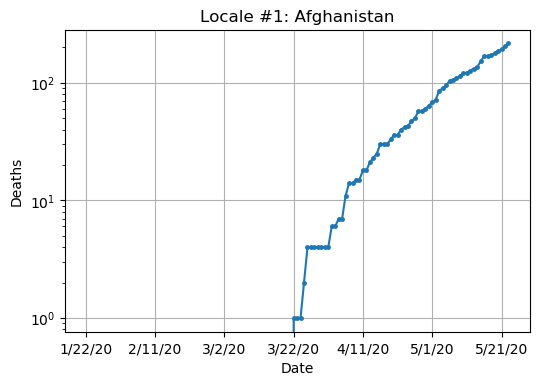

In [22]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 100:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title(f'Locale #{idx + 1}: {values.iloc[idx, 0]}')
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [23]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [24]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [25]:
values_melt.sample(5)

,locale,date,value
26155,Croatia,2020-04-29,67
14198,Equatorial Guinea,2020-03-15,0
24397,San Marino,2020-04-22,40
2265,Italy,2020-01-30,0
30961,Fiji,2020-05-17,0


Filter by the minimum required metric value:

In [26]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [27]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [28]:
values_melt.sample(5)

,locale,date,value
21400,Germany,2020-04-11,3.437116
19069,Poland,2020-04-02,1.755875
29083,Cuba,2020-05-10,1.886491
23204,China/Hubei,2020-04-18,3.654369
20218,Algeria,2020-04-07,2.285557


## Construct Final Datasets

In [29]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + [f'value_d{idx}' for idx in range(-days_history + 1, 1)]
                                    + [f'value_d+{days_horizon}'])

In [30]:
final_schema

,locale,date,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+21


In [31]:
train_to_append_list = []
pred_to_append_list = []

In [32]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [33]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [34]:
train = train.sample(frac=1, random_state=random_state)
train = train.sort_values('date')

In [35]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

In [36]:
train.head()

value_d-13  value_d-12  value_d-11  value_d-10  \
locale      date                                                         
China/Hubei 2020-02-07    1.602060    1.716003    1.880814    2.096910   
            2020-02-08    1.716003    1.880814    2.096910    2.096910   
            2020-02-09    1.880814    2.096910    2.096910    2.209515   
            2020-02-10    2.096910    2.096910    2.209515    2.309630   
            2020-02-11    2.096910    2.209515    2.309630    2.396199   

                        value_d-9  value_d-8  value_d-7  value_d-6  value_d-5  \
locale      date                                                                
China/Hubei 2020-02-07   2.096910   2.209515   2.309630   2.396199   2.544068   
            2020-02-08   2.209515   2.309630   2.396199   2.544068   2.617000   
            2020-02-09   2.309630   2.396199   2.544068   2.617000   2.680336   
            2020-02-10   2.396199   2.544068   2.617000   2.680336   2.739572   
            2020-02-11   2.544068   2.617000   2.680336   2.739572   2.790988   

                        value_d-4  value_d-3  value_d-2  value_d-1  value_d0  \
locale      date                                                               
China/Hubei 2020-02-07   2.617000   2.680336   2.739572   2.790988  2.844477   
            2020-02-08   2.680336   2.739572   2.790988   2.844477  2.892095   
            2020-02-09   2.739572   2.790988   2.844477   2.892095  2.940018   
            2020-02-10   2.790988   2.844477   2.892095   2.940018  2.988559   
            2020-02-11   2.844477   2.892095   2.940018   2.988559  3.028571   

                        value_d+21  
locale      date                    
China/Hubei 2020-02-07    3.428459  
            2020-02-08    3.435685  
            2020-02-09    3.441066  
            2020-02-10    3.447623  
            2020-02-11    3.452553

In [37]:
pred.head()

,,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+21
locale,date,,,,,,,,,,,,,,,
Afghanistan,2020-05-23,2.079181,2.086360,2.103804,2.120574,2.133539,2.184691,2.225309,2.227887,2.238046,2.250420,2.271842,2.285557,2.311754,2.334454,NaN
Algeria,2020-05-23,2.700704,2.705008,2.711807,2.717671,2.723456,2.729165,2.733999,2.738781,2.744293,2.748963,2.754348,2.759668,2.764923,2.772322,NaN
Andorra,2020-05-23,1.681241,1.681241,1.681241,1.690196,1.690196,1.690196,1.707570,1.707570,1.707570,1.707570,1.707570,1.707570,1.707570,1.707570,NaN
Argentina,2020-05-23,2.484300,2.496930,2.503791,2.517196,2.547775,2.551450,2.559907,2.571709,2.582063,2.594393,2.605305,2.619093,2.636488,2.648360,NaN
Armenia,2020-05-23,1.653213,1.662758,1.672098,1.681241,1.690196,1.716003,1.740363,1.778151,1.785330,1.806180,1.826075,1.845098,1.869232,1.886491,NaN


Check the size of the dataset:

In [38]:
print(f'The training data has {train.shape[0]} samples')
print(f'Predictions will be made for {pred.shape[0]} locales')

The training data has 1539 samples
Predictions will be made for 89 locales


## Model Training and Validation

In [39]:
# model = linear_model.LassoCV(
#     eps=1e-8,
#     fit_intercept=True,
#     max_iter=100000,
#     n_jobs=-1,
#     random_state=random_state,
# )

In [40]:
model = linear_model.ElasticNetCV(
    l1_ratio=[pow(x, 1/3) for x in np.linspace(0.001, 1, 10)],
    eps=1e-8,
    n_alphas=100,
    fit_intercept=True,
    max_iter=100000,
    cv=TimeSeriesSplit(),
    n_jobs=-1,
    random_state=random_state,
    selection='random',
)

In [41]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=1e-08,
             fit_intercept=True,
             l1_ratio=[0.10000000000000002, 0.48202845283504603,
                       0.6064126994506963, 0.6938232073815802,
                       0.763460672149231, 0.822289851862149, 0.8737260372210359,
                       0.9197289686814338, 0.961539774357182, 1.0],
             max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
             positive=False, precompute='auto', random_state=0,
             selection='random', tol=0.0001, verbose=0)

In [42]:
model.coef_

array([ 0.1138254 ,  0.        , -0.        , -0.18716427, -0.06673191,
       -0.26308524, -0.24200981, -0.32471387, -0.25304142, -0.13757294,
       -0.13732392, -0.03491474, -0.        ,  2.49911503])

In [43]:
model.intercept_

0.14634122861125132

In [44]:
if isinstance(model, sklearn.linear_model._coordinate_descent.ElasticNetCV):
    print(model.l1_ratio_)

0.961539774357182


In [45]:
model.alpha_

6.66558939596767e-05

In [46]:
# min(model.alphas_), max(model.alphas_)

Cross-validated mean absolute error:

In [47]:
mean_abs_errors = -cross_val_score(
    estimator=linear_model.ElasticNet(
        alpha=model.alpha_,
        l1_ratio=model.l1_ratio_,
        max_iter=100000,
        random_state=random_state,
        selection='random',
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(),
    n_jobs=-1,
)

In [48]:
sorted(mean_abs_errors)

[0.06687362409256518,
 0.07229877409201198,
 0.08207190346865663,
 0.0852324957600876,
 0.105327441555615]

## Model Selection Information

In [49]:
pd.DataFrame(
    data={
        'days_history': days_history,
        'days_selected': (model.coef_ != 0).sum(),
        'metric_min': metric_min[metric],
        'n_samples': train.shape[0],
        'samples_per_param': train.shape[0]/(days_history + 1),
        'mean_error': mean_abs_errors.mean(),
    },
    index=[0],
)

,days_history,days_selected,metric_min,n_samples,samples_per_param,mean_error
0,14,11,32,1539,102.6,0.082361


## Predictions

In [50]:
pred[f'value_d+{days_horizon}'] = model.predict(pred.iloc[:, :-1])

In [51]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [52]:
pred

,,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+21
locale,date,,,,,,,,,,,,,,,
Afghanistan,2020-05-23,120,122,127,132,136,153,168,169,173,178,187,193,205,216,374
Algeria,2020-05-23,502,507,515,522,529,536,542,548,555,561,568,575,582,592,751
Andorra,2020-05-23,48,48,48,49,49,49,51,51,51,51,51,51,51,51,63
Argentina,2020-05-23,305,314,319,329,353,356,363,373,382,393,403,416,433,445,662
Armenia,2020-05-23,45,46,47,48,49,52,55,60,61,64,67,70,74,77,143
Australia/New South Wales,2020-05-23,44,44,45,45,45,45,45,46,46,47,47,48,48,48,63
Austria,2020-05-23,618,620,623,624,626,628,629,629,629,632,633,633,635,639,737
Azerbaijan,2020-05-23,32,32,33,35,35,36,36,39,40,41,43,44,46,49,87
Bangladesh,2020-05-23,228,239,250,269,283,298,314,328,349,370,386,408,432,452,825
